In [1]:
import os
import pathlib

import numpy as np
import pandas as pd

import shapely.geometry
import rasterio
import rasterio.plot
import rasterio.mask

import rasterio.features
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import cmasher

from util_data_exploration import get_tile_images, reconvert_np_to_rasterio_dataset

## Contents of notebook
- collecting all relevant scenario folders for processing
- processing terrain maps, flood maps, and Rotterdam district areas

This notebook specifically processes flood scenario data from LIWO, filters it with the terrain (DSM) data from AHN, and separates the flood data per district (wijk) in Rotterdam.

## Usage notes
- LIWO flood data should be placed in the data/flood_breaks directory, as separate directories per scenario. This script should automatically detect the scenarios.
- The AHN terrain data (Digital Surface Mapping) data file is pre-processed and present in data/rdam_topo_bool_map.tif . The original raw data from AHN consists of multiple tiles and needed to be combined together, which was done in a different script (TODO: explain that script)
- the Rotterdam district vector data is pre-processed and present in data/wijk_geometries.shp. Note that this script takes only a subset of the data, since industry-only districts and the port district of R'dam is omitted. Note that the district labels across different datasets can be different (some explicitly list all the industry districts, others just lump the industry districts as a generic 'bedrijventerrein' catch-all category)

In [2]:
# Search for flood scenario directories in data/flood_breaks
base_path = '../data/flood_breaks'

# find valid folders
target_ending = '.tif'  # look for tiff files only
scenario_paths = []  # directory paths to the scenario files
scenario_names = []  # names of the scenarios
for path in os.listdir(f'{base_path}'):
    if '.zip' not in path:  ## exclude zip files, look for folders
        for item in os.listdir(f'{base_path}/{path}'):
            if target_ending in item:  # if tiff file
                scenario_paths.append(f'{base_path}/{path}/{item}')  # save relative path
                scenario_names.append(path.lower())  # the scenario names are on the directory, not the tif file itself.

In [55]:
# extract and filter Rotterdam district VECTOR data for filtering later on
wijken = gpd.read_file('../data_model_inputs/rdam_districts/rdam_districts_city_only.shp')


## Process Rotterdam terrain data for filtering
The following block processes the terrain data from AHN. The pre-processed data is a rasterio dataset object containing 0 for water and 1 for land, and will be used to filter out inland bodies of water in the flood dataset (some water bodies are marked as flooded, even though there won't be any buildings on them).

The procedure uses a hacky method based on <https://gis.stackexchange.com/questions/363183/crop-two-rasters-to-common-extent-where-pixelvalues-are-not-nodata>, converting the terrain (raster) to vector to be used as a mask for the flood map.

In [4]:
# Read rotterdam land bool map, generated from map_explore.ipynb
terrain_bool_ds = rasterio.open('../data/rdam_topo_bool_map.tif')
terrain_bool_map = terrain_bool_ds.read(1)  # derived from map_explore.ipynb
# in the map 0 = water, 1 = land
# convert terrain map (raster) to vector map for masking.

knockout_meta = terrain_bool_ds  # with metadata
knockout = terrain_bool_map
geoms_water = []
geoms_land = []

# convert the raster to vector features, for masking out inland water bodies later on
for geometry, raster_value in rasterio.features.shapes(knockout, transform=knockout_meta.transform):
    if raster_value == 0:  # 0 = water, 1 = land
        geoms_water.append(geometry)
    else:
        geoms_land.append(geometry)


## Processing flood data, with filtering/masking from the terrain map and district boundaries.
This section processes the flood data with the terrain maps (to ignore inland water) and district geometry. The flood data will be separated according to the districts, and saved into a pandas dataframe (currently 'data_model_inputs/flood_scenarios_v2.pickletable') for further usage. An entry in the dataframe includes the distribution of land 'tiles'.



In [5]:
# NEW RETROFIT FOR THESIS PLOTTING

# use generated vectors as mask. Should be less sensitive to differential spatial resolution than older method in map_explore.ipynb

# TODO: list out assumptions in this datacleaning

temp_dict = {}  # for temporary storage, for generation of pandas dataframe
flooded_pct_threshold = .01   # percentage of flooded landmass to be considered significant (1%)
force_equalise = True  # bool argument to force non-data (but still landmass) to 0 (TODO: explain)

for idx, path in enumerate(scenario_paths):
    with rasterio.open(path) as input_flood_ds:  # open the flood scenario in 'safe' manner
        input_flood_scenario = scenario_names[idx]  # get scenario name
        # first mask out inland water bodies to minimise invalid flood values
        out_flood_img, out_transform = rasterio.mask.mask(dataset=input_flood_ds,
                                                          shapes=geoms_land,
                                                          crop=True,
                                                          nodata=np.nan,
                                                          pad=True)
        # use the first band (count=1) for further cropping, it contains all flood data. Other bands contain bins of flood depths
        out_flood_ds = reconvert_np_to_rasterio_dataset(raster=out_flood_img[0, :, :],
                                                        transform=out_transform,
                                                        count=1)  # only use the 1st band

        # crop out the flood map with the wijk borders, only for the wijken of interest
        cropped, transform = rasterio.mask.mask(dataset=out_flood_ds,
                                                shapes=wijken['geometry'],
                                                crop=True,
                                                nodata=np.nan)

        # filter out very small flooding that can be considered negligible (for plotting)
        cropped = np.where(cropped < flooded_pct_threshold, 0., cropped)
        temp_dict[input_flood_scenario] = (cropped, transform)  #  save as tuple for plotting

        # cut out the flood submaps with the R'dam district shapes
        # filter out districts that are not affected
        # caveat: dependent on which wijken are collected for this study (eg. the business-specific areas are not included)
        # for wijk in wijken.index:  # numeric index
        #     geo = wijken.geometry[wijk]
        #
        #     # cut out flood values belonging to the specific wijk
        #     try:
        #         submap, transform = rasterio.mask.mask(dataset=out_flood_ds,
        #                                                shapes=[geo],
        #                                                crop=True,
        #                                                nodata=np.nan)
        #         # process to see if map contains any valid flood values
        #         submap_depths = submap[submap > 0.]  # 1d array of parcels higher than 0
        #         if submap_depths.size > 0:  # if there are areas higher than 0
        #
        #             # if non-data exists on the cropped submap, force them to 0. (A)
        #             if force_equalise:
        #                 submap = np.where(submap < 0., 0., submap)
        #
        #             # gets the distribution of land parcels. Used for sampling buildable land
        #             flatten = submap[submap >= 0.]
        #             if submap_depths.size / flatten.size >= flooded_pct_threshold: # if flooded proportion is higher than threshold
        #
        #                 # save to dict for DataFrame generation
        #                 temp_dict[f'{input_flood_scenario},{wijk}'] = {'scenario': input_flood_scenario,
        #                                                                'wijk': wijk,
        #                                                                'submap': submap,
        #                                                                'transform': transform,
        #                                                                'flatten': flatten}
        #
        #     except ValueError:  # occurs if the map geometry doesn't overlap flood area
        #         pass  # no appending to flood_submaps
        #         # flood_submaps[name] = None # could also ignore

boerengatsluis_1e6 created


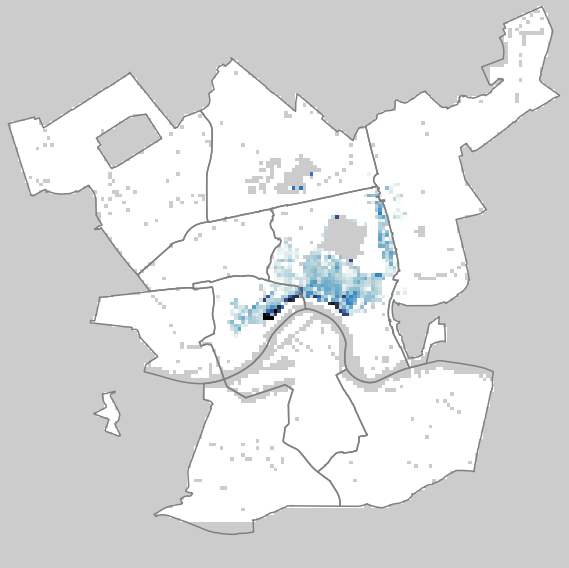

In [6]:
# plot the flood dataset with the map borders

colour_choice = mpl.colormaps['GnBu']
modded = ListedColormap(colour_choice(np.linspace(0.2, 1.0, 205)))
test_mode = True
if test_mode:
    plt.ion()  # plot in notebook
else:
    plt.ioff() # only output as file

for fld_scenario, fld_cropped in temp_dict.items():
    fld_map, fld_transform = fld_cropped

    fig, ax = plt.subplots(figsize=(10,8))

    # plot cropped floodmap with colour
    rasterio.plot.show(fld_map, transform=fld_transform, ax=ax, cmap=cmasher.arctic_r, vmin=0, vmax=3.)
    # plot borders of wijken of interest
    wijken.boundary.plot(ax=ax, edgecolor='grey')
    brightness = 0.8  # for RGB setting of grey
    fig.set_facecolor((brightness, brightness,brightness))  # create grey background
    ax.axis('off')  # turn off axes
    plt.tight_layout()  # calculate plot spacing for output
    print(f'{fld_scenario} created')

    if test_mode:
        break
    else:
        # save fig and clear for next iteration
        fig.savefig(f'../data_model_outputs/fld_plots/{fld_scenario}.png', dpi=500)
        fig.clf()
        ax.cla()



In [7]:
if temp_dict:  # if dict is not empty

    flood_submaps_df = pd.DataFrame.from_dict(temp_dict, orient='index').astype(
        {'scenario': 'category',
         'wijk': 'category'})
    flood_submaps_df['flatten_size'] = [v.size for v in flood_submaps_df.flatten]
    flood_submaps_df['submap_size'] = [v.size for v in flood_submaps_df.submap]

    # clean and truncate floodmaps since the flood-data borders are inconsistent

    # save dataframe to disk (uncomment when necessary)
    # flood_submaps_df.to_pickle('../data_model_inputs/flood_scenarios_v2.pickletable')

KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'scenario' not found in columns."

# Geoplots with transaction data

In [39]:
import colorcet
from matplotlib.cm import get_cmap
from matplotlib.colors import TwoSlopeNorm, CenteredNorm
import seaborn as sns

In [84]:
control_df = pd.read_pickle('control_df.pickletable')
control_df.step = control_df.step.astype(int) # convert from categorical to numerical
control_df = control_df.loc[control_df.step == control_df.step.max(),:]

In [90]:
# use the control_df as a baseline, find the mean per district and subtract them from the original
control_distr_descr = control_df.groupby('district')['h_value_d'].agg(np.mean)
control_df['h_value_dc'] = control_df['h_value_d']

In [ ]:
all_t_1f_df = pd.read_pickle('all_t_1f_df.pickletable')  # warning large dataframe
# truncate to only the last step, saves memory
all_t_1f_df = all_t_1f_df.loc[all_t_1f_df.step == all_t_1f_df.step.max(), :]

In [89]:
# add new column
all_t_1f_df['h_value_dc'] = all_t_1f_df['h_value_d'] - all_t_1f_df['district'].map(control_distr_descr).astype(float)

In [56]:
wijken_plot = wijken.set_index('index')

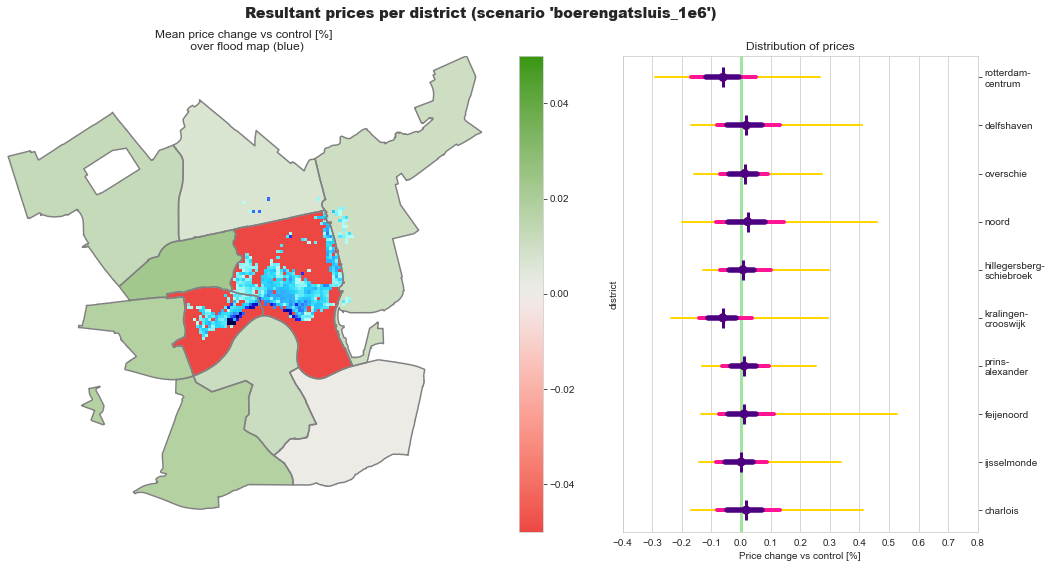

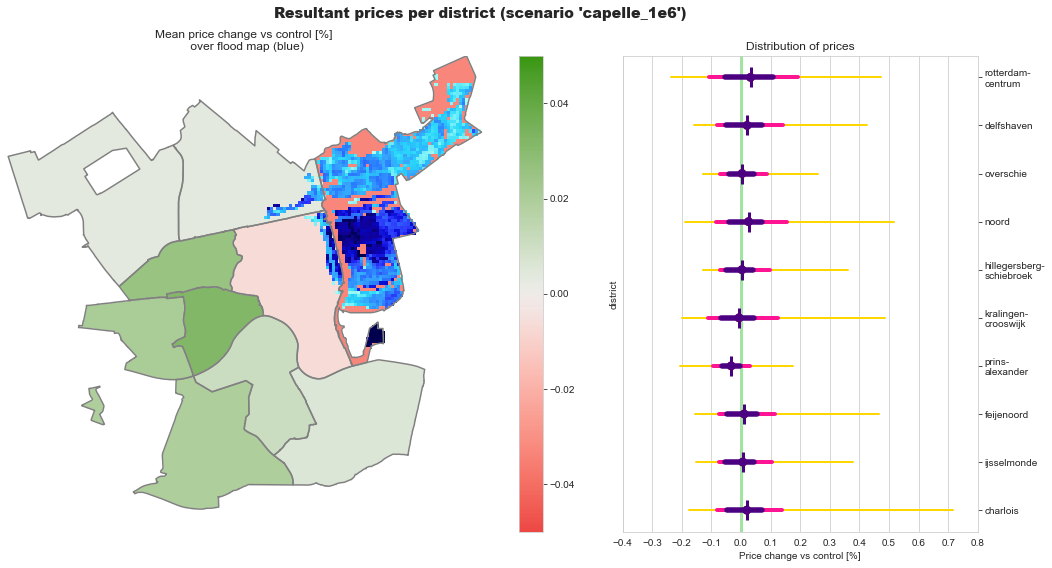

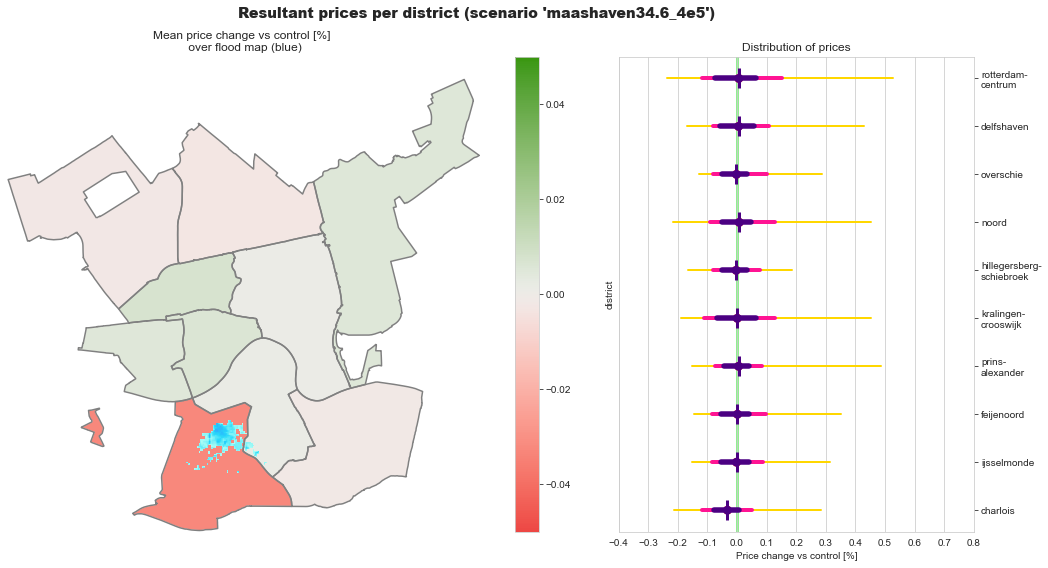

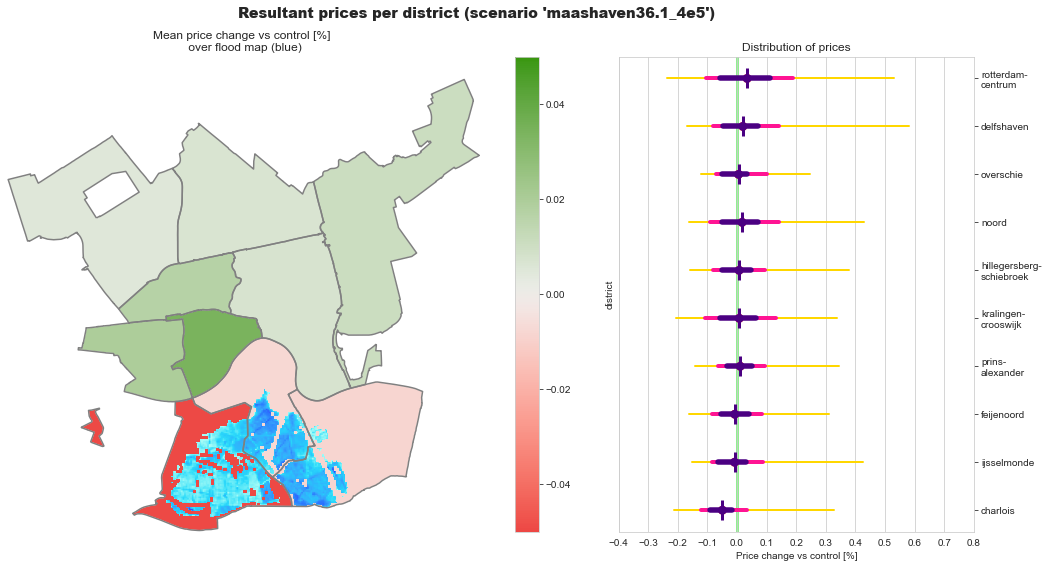

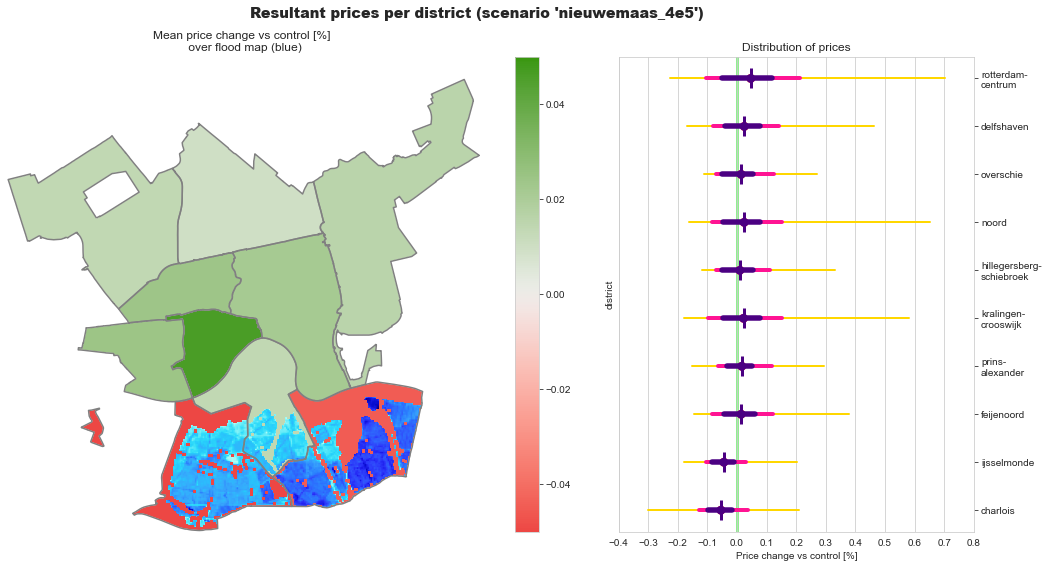

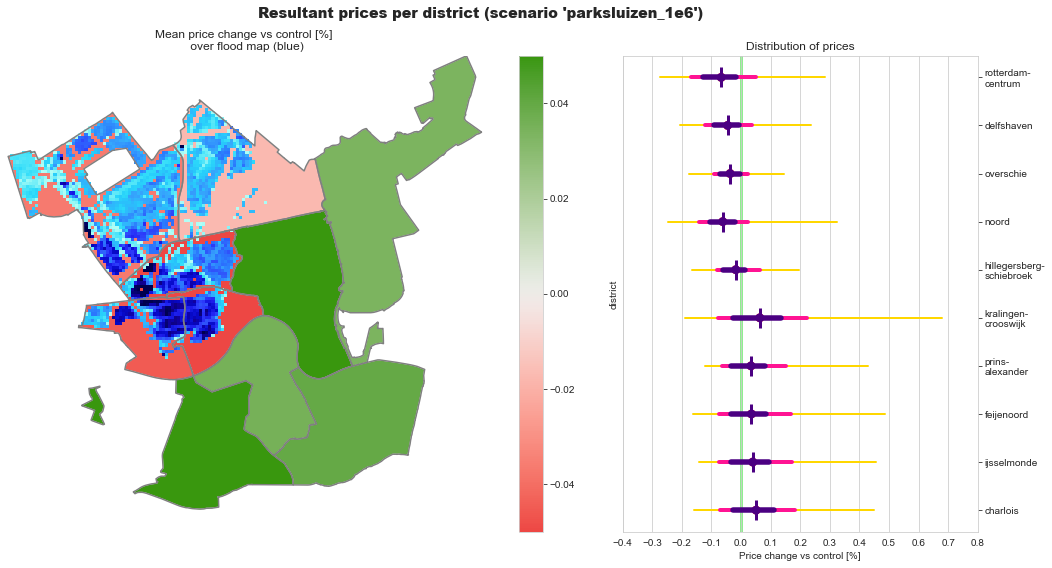

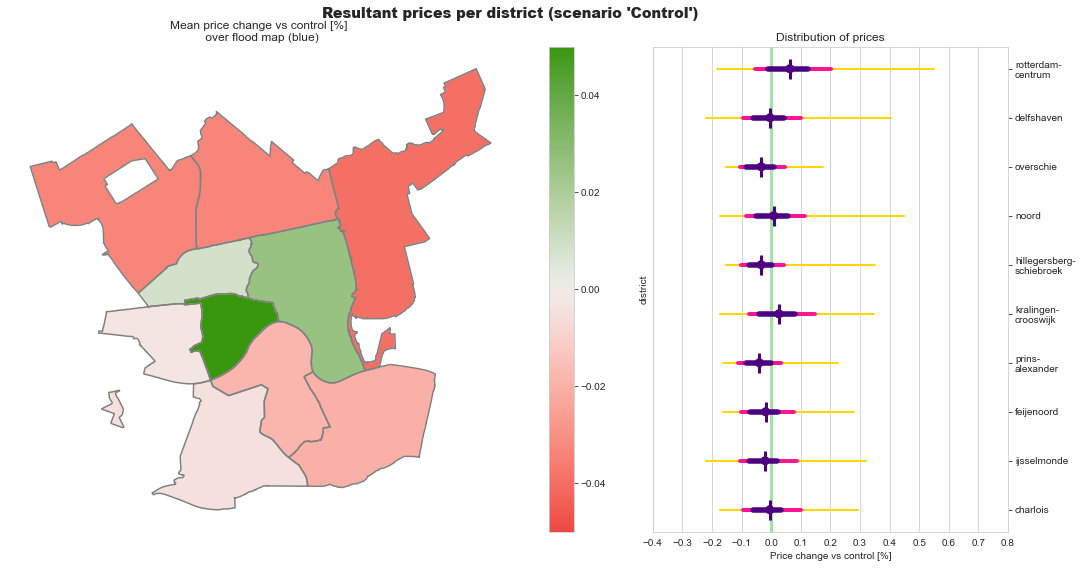

In [111]:
# 3 key items: plot mean, plot data, and plot distributions in a subplot
# access tempdict to get the maps
wijken_relabel = dict(zip(wijken_plot.index, wijken_plot.index.str.replace('-', '-\n')))
temp_dict['Control'] = (None, None)  # add control set
for fld_scenario, fld_cropped in temp_dict.items():

    fld_map, fld_transform = fld_cropped

    fig, axes = plt.subplots(ncols=2, figsize=(16,8), gridspec_kw={'width_ratios': [2, 1]})

    if fld_scenario != 'Control':
        plot_flood = True
        rep_df = all_t_1f_df.loc[all_t_1f_df.Scenario==fld_scenario, :]
        # convert fld map to just only show flooded tiles
        fld_map = np.where(fld_map==0, np.nan, fld_map)
    elif fld_scenario == 'Control':
        plot_flood = False
        rep_df = control_df
    else: raise ValueError
    rep_df_grp = rep_df.groupby(by='district')
    rep_df_stats = rep_df_grp['h_value_dc'].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])


    cmap_mean = get_cmap('cet_CET_D3_r')
    norm = CenteredNorm(halfrange=0.05)
    wijken_plot.plot(column=rep_df_stats['mean'], cmap=cmap_mean, legend=True, norm= norm, ax=axes[0],zorder=0.5)


    if plot_flood: # plot for flooding, control doesn't have a valid dataset and will raise an error
        rasterio.plot.show(fld_map, transform=fld_transform, ax=axes[0], cmap=get_cmap('cet_kbc_r'), vmax=3., zorder=0.6)
    wijken_plot.boundary.plot(ax=axes[0], edgecolor='grey')
    axes[0].axis('off')

    # plotting the distribution on the right of the diagram
    for interq_range in [100,80,50]:
        if interq_range == 100:
            colour = 'gold'
            errwidth= 2
        elif interq_range == 80:
            colour = 'deeppink'
            errwidth = 4
        elif interq_range == 50:
            colour= 'indigo'
            errwidth = 5.5
        else: raise ValueError

        # plot error bars
        sns.pointplot(rep_df,y='district',x='h_value_dc', order=wijken_plot.index, orient='h', ax=axes[1], errorbar=('pi',interq_range), join=False, color=colour, errwidth=errwidth)


    # attempt to plot with text, messy
    # wijken_plot['centroids'] = wijken_plot['geometry'].centroid
    #
    # for idx, row in wijken_plot.iterrows():  # introduce names into the map
    #     if " " in idx:
    #         idx = idx.replace(" ", '\n')
    #     elif "-" in idx:
    #         idx = idx.replace('-', '-\n')
    #     axes[0].text(s=idx, x=row['centroids'].x, y=row['centroids'].y, fontsize='large', horizontalalignment='center', **{'color': 'black'})

            # plot mean point

    # plot mean points on distribution
    axes[1].plot(rep_df_stats.loc[wijken_plot.index,'mean'], wijken_plot.index,marker="|", markersize=20,
                 markeredgecolor='indigo', markeredgewidth=3,
                 zorder=2.1, linestyle='None')
    axes[1].set_yticklabels(wijken_relabel.values())
    axes[1].axvline(0., color='lightgreen',zorder=0.1, linewidth=3)
    axes[1].yaxis.tick_right()  # places ticks to the right
    axes[1].set_xlim(xmin=-0.4, xmax=0.8)
    axes[1].set_xticks(np.arange(-40, 81, 10)/100)

    axes[0].set_title('Mean price change vs control [%] \n over flood map (blue)')
    axes[1].set_xlabel("Price change vs control [%]")
    axes[1].set_title("Distribution of prices")
    fig.suptitle(f"Resultant prices per district (scenario '{fld_scenario}')", fontsize='x-large', fontweight='black')
    fig.tight_layout()
    fig.savefig(f'../data_model_outputs/fld_plots/resultant_{fld_scenario}.jpg', dpi=300)


